In [ ]:
import sys
sys.path.append('..')

from scripts.data_loaders.common import show_sample
from scripts.data_loaders.L2ARCTIC import L2ArcticDataset, all_arctic_speaker_splits, SPEAKERS
from scripts.eval.core import evaluate
from scripts.ipa_transcription.wav2vec2 import transcribe_batch

import pandas as pd

import torch
from transformers import AutoProcessor, AutoModelForCTC

from IPython.display import clear_output
clear_output()

# Load Data

In [2]:
speaker_info_df = pd.DataFrame.from_dict(SPEAKERS, orient='index')
speaker_info_df.head()

,gender,native-language
ABA,M,Arabic
SKA,F,Arabic
YBAA,M,Arabic
ZHAA,F,Arabic
BWC,M,Chinese


In [3]:
suitcase = L2ArcticDataset(split='suitcase_corpus')
dataset = all_arctic_speaker_splits()

IPA: jɛˈsʌˈmɪˈtsiˈmzɪffɹʌˈmðʌfɝˈsbɪˈktʃɝzzɪsɪzlaɪˈkʌbɪˈktʃɝoʊfʌˈmʌdaʊˈntaʊˈnɔfʌsiˈtiwɪˈzʌbɪˈkhɔtɛˈlsʌndtuˈtuˈbiˈpʌlwʌˈnwʊˈmʌnæˈndwʌˈnmæˈnwɛˈnduˈzɪˈshətɛˈlzʌnbɪkʌzzɛˈɹɪˈznoʊsɔɪnʌˈɔˈnzʌɔˈnzʌwɛˈndoʊzɪtʃwʌˈnlaɪˈkɹæˈʒdɪˈntuɪtʃʌˈðɝsʌndɑftɝðæˈtɑftɝkɹæˈʃʌˈðeɪˈfɑnðæˈtsɝbɹaɪˈzɪŋɡɹlizɛhæˈvdʌsɛmkɑˈlɝoʊvzʌbæˈkʌndɪhɪllaɪˈkɪˈtsɪssɪˈmʌlɝbæˈksæˈkʃʌliʌndɑftɹkɹæˈʃɪŋɡɪvɹiwʌˌndoʊˈkzɛiˈtʃʌˈdɹzbæˈkʌndɑftɝðæˈtwɛˈnwɛˈntbæˈktuˈðɛɹɹuˈmzðɛfaʊˈnðæˈtzʌˈmæˈndoʊˈkzʌˈdɹɛˈsɔvzʌˈɑftɝhɪˈzoʊbʌnɪŋtszʌˈzʌˈbæˈkhɪzbæˈkhiˈfʌnzʌthiˈtɔˈkʌˈhiˈfaʊˈndlaɪˈkʌɹɛˈddɹɛˈsɔfʌwʊˈmʌnʌnzʌwʊˈmʌnfɑnzʌtʌˈeɪˈjɪloʊtɔɪʌˈvðʌmæˈnʌndʌmnɑˈtʃʊˈɹwʌˈtswʌˈthæˈbʌnæˈftɝθæˈθ


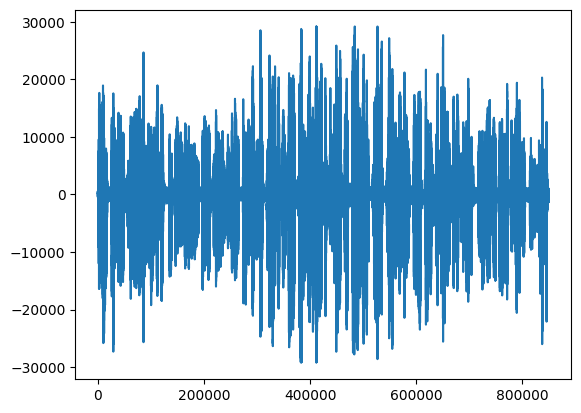

In [4]:
show_sample(suitcase[0])

IPA: ɡɑˈdbəlɛˈsʌmaɪˈhɔbaɪˈwɪˈlɡɔɑˈnsiˈɪŋɡðɛˈmfɝɛˈvɝ


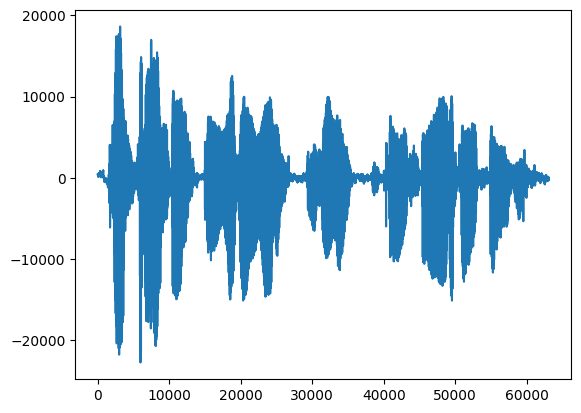

In [5]:
show_sample(dataset[152])

# Eval

In [6]:
# MODEL_ID = "KoelLabs/xlsr-timit-a1"
MODEL_ID = "KoelLabs/xlsr-timit-b0"
# MODEL_ID = "KoelLabs/xlsr-timit-c0"
# MODEL_ID = "KoelLabs/xlsr-timit-d0"
# MODEL_ID = "KoelLabs/xlsr-timit-e0"
# MODEL_ID = "KoelLabs/xlsr-timit-b1"
# MODEL_ID = "KoelLabs/xlsr-timit-c1"
# MODEL_ID = "KoelLabs/xlsr-timit-d1"
# MODEL_ID = "KoelLabs/xlsr-timit-e1"
# MODEL_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"
# MODEL_ID = "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"
# MODEL_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"
# MODEL_ID = "vitouphy/wav2vec2-xls-r-300m-timit-phoneme"
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
torch.mps.empty_cache()
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE)

In [7]:
transcribe_batch([dataset[231]], model, processor)

['aɪsəpoʊzjʊbɪɡiðʌlɪŋɡʊɑbəmʌŋɡizəʔeɪndʒinz']

In [8]:
BATCH_SIZE = 4
average_cer = 0
average_feature_distance = 0
amount = len(dataset)
for i in range(0, amount, BATCH_SIZE):
    torch.mps.empty_cache()
    size = min(BATCH_SIZE, amount - i)
    transcriptions = transcribe_batch([dataset[i+j] for j in range(size)], model, processor)
    for j in range(size):
        cer_score, feature_distance = evaluate(dataset[i+j][0], transcriptions[j])
        average_cer += cer_score
        average_feature_distance += feature_distance

print(f"CER: {average_cer / amount}")
print(f"FER: {average_feature_distance / amount}")

CER: 0.4696452764905692
FER: 1.0704279611566956


Dataset:
A1 CER: 0.3698741542956077
A1 FER: 36.43848985829397

B0 CER: 0.37287099149688263
B0 FER: 35.6378855237566

B1 CER: 0.4158259760991502
B1 FER: 43.74375

C0 CER: 0.37458272381362284
C0 FER: 37.0293310641845

C1 CER: 0.41231864722074996
C1 FER: 46.5975

D0 CER: 0.40078148423494
D0 FER: 45.48583333333333

D1 CER: 0.3968286610949121
D1 FER: 45.26375

E0 CER: 0.4002234246412203
E0 FER: 44.5325

E1 CER: 0.4034121878040484
E1 FER: 44.44583333333333

Ginic CER: 0.33515909906893876
Ginic FER: 31.898513475965547

Vitouphy CER: 0.6134974617724104
Vitouphy FER: 28.777768130036122

ARCTIC Finetune CER: 0.3322918758657274
ARCTIC Finetune FER: 9.547083333333333

Facebook 60 CER: 1.2455362697067198
Facebook 60 FER: 22.629879827729926

In [9]:
# MODEL_ID = "KoelLabs/xlsr-timit-a1"
# MODEL_ID = "KoelLabs/xlsr-timit-b0"
# MODEL_ID = "KoelLabs/xlsr-timit-c0"
# MODEL_ID = "KoelLabs/xlsr-timit-d0"
# MODEL_ID = "KoelLabs/xlsr-timit-e0"
# MODEL_ID = "KoelLabs/xlsr-timit-b1"
# MODEL_ID = "KoelLabs/xlsr-timit-c1"
# MODEL_ID = "KoelLabs/xlsr-timit-d1"
# MODEL_ID = "KoelLabs/xlsr-timit-e1"
MODEL_ID = "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa"
# MODEL_ID = "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme"
# MODEL_ID = "facebook/wav2vec2-lv-60-espeak-cv-ft"
# MODEL_ID = "vitouphy/wav2vec2-xls-r-300m-timit-phoneme"
DEVICE = 'cpu' # force cpu since we run out of memory with mps when using suitcase_corpus
processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForCTC.from_pretrained(MODEL_ID).to(DEVICE)
BATCH_SIZE = 1 
average_cer = 0
average_feature_distance = 0
amount = 10 # len(suitcase)
for i in range(0, amount, BATCH_SIZE):
    torch.mps.empty_cache()
    size = min(BATCH_SIZE, amount - i)
    # transcriptions = transcribe_batch([suitcase[i+j] for j in range(size)])
    transcriptions = transcribe_batch([suitcase[i+j] for j in range(size)], model, processor)
    for j in range(size):
        label, pred = suitcase[i+j][0], transcriptions[j]
        # label, pred = fastdtw_phoneme_alignment(suitcase[i+j][0], transcriptions[j])
        cer_score, feature_distance = evaluate(label, pred)
        average_cer += cer_score
        average_feature_distance += feature_distance

print(f"CER: {average_cer / amount}")
print(f"FER: {average_feature_distance / amount}")

CER: 0.4588833755151132
FER: 0.9861889702416013


Suitcase:
A1 CER: 0.41624745299303717
A1 FER: 552.1363636363636

B0 CER: 0.4167442976333918
B0 FER: 530.3664772727273

CER: 0.4124469760409197
FER: 527.1789772727273

CER: 0.41435708216639516
FER: 526.0482954545455

B1 CER: 0.4340377467925079
B1 FER: 561.34375

C0 CER: 0.4270605124538044
C0 FER: 574.0397727272727

C1 CER: 0.4223168913619132
C1 FER: 557.3522727272727

D0 CER: 0.42078344837923803
D0 FER: 560.0284090909091

D1 CER: 0.4108961905003216
D1 FER: 548.3920454545455

E0 CER: 0.4194837687154946
E0 FER: 554.9176136363636

E1 CER: 0.41206782010323106
E1 FER: 544.3295454545455

Ginic CER: 0.36689385788519396
Ginic FER: 505.0113636363636

ARCTIC Finetune CER: 0.5390104503648039
ARCTIC Finetune FER: 379.1136363636364

Facebook 60 CER: 1.3342845063812439
Facebook 60 FER: 461.0880681818182

Vitouphy CER: 0.6501964754239954
Vitouphy FER: 490.4744318181818